# Label scores analyses

This notebook performs the following analysis steps:
* aggregating data across seeds, by phenomenon, by model, by label type
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [330]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [331]:
# read data and combine
model_names = ["llama2", "flan-t5-xl", "gpt-3.5-turbo-instruct"]
label_types = ["label_alpha", "label_numeric"]

raw_df = pd.DataFrame()
for model in model_names:
    print("Model ", model)
    for label_type in label_types:
        results_path = glob.glob(f"../results/log_probs/{model}/*/label_scores/{label_type}/*.csv")
        print("Number of files to concat ", len(results_path))
        for p in results_path:
#             print("Reading file ", p)
            d = pd.read_csv(p)
            d["metric"] = "label_score"
            d["label_type"] = label_type
            
            raw_df = pd.concat([raw_df, d])    

Model  llama2
Number of files to concat  35
Number of files to concat  35
Model  flan-t5-xl
Number of files to concat  35
Number of files to concat  35
Model  gpt-3.5-turbo-instruct
Number of files to concat  35
Number of files to concat  31


In [332]:
print(len(raw_df))
raw_df.head()

19330


,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,token_probs,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type
0,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,A,target,...,[0.0021805406873923253],0.003313,0.003313,0.002181,1.519248,-5.709967,-5.709967,0.931755,label_score,label_alpha
1,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,B,incorrect_straightforward,...,[0.0018741641342209612],0.002067,0.002067,0.001874,1.103044,-6.181519,-6.181519,0.984382,label_score,label_alpha
2,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,C,associative_nonsequitur,...,[0.003587298613933627],0.001646,0.001646,0.003587,0.458951,-6.409168,-6.409168,1.138324,label_score,label_alpha
3,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,D,funny_nonsequitur,...,[0.002218916267492813],0.001804,0.001804,0.002219,0.812816,-6.317986,-6.317986,1.033916,label_score,label_alpha
4,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,E,neutral_nonsequitur,...,[0.0014657024465339016],0.000984,0.000984,0.001466,0.671308,-6.923948,-6.923948,1.061073,label_score,label_alpha


In [333]:
raw_df.columns

Index(['model_name', 'temperature', 'seed', 'item_id', 'phenomenon', 'prompt',
       'prior_prompt', 'question', 'options', 'option_names',
       'shuffled_options', 'shuffled_option_names', 'option_numbering',
       'token_cond_log_probs', 'token_cond_probs', 'prior_token_log_probs',
       'null_prior_token_log_probs', 'token_probs', 'sentence_cond_probs',
       'mean_sentence_cond_probs', 'prior_sentence_probs', 'sentence_mi',
       'sentence_surprisal', 'mean_sentence_surprisal',
       'sentence_mi_surprisal', 'metric', 'label_type'],
      dtype='object')

In [334]:
coherence_df = raw_df[raw_df['phenomenon'] == 'coherence']
deceits_df = raw_df[raw_df['phenomenon'] == 'deceits']
humours_df = raw_df[raw_df['phenomenon'] == 'humour']
indirect_df = raw_df[raw_df['phenomenon'] == 'indirect_speech']
irony_df = raw_df[raw_df['phenomenon'] == 'irony']
maxims_df = raw_df[raw_df['phenomenon'] == 'maxims']
metaphor_df = raw_df[raw_df['phenomenon'] == 'metaphor']

For the sanity check, here are the expected numbers of rows in each phenomenon, computed as: models * seed * items * options

* coherence: 3 * 5 * 40 * 2 = 1200 => 2400
* deceits: 3 * 5 * 20 * 4 = 1200 => 2400
* humour: 3 * 5 * 25 * 5 = 1875 => 3750
* indirect: 3 * 5 * 20 * 4 = 1200 => 2400
* irony: 3 * 5 * 25 * 4 = 1500 => 3000
* maxims: 3 * 5 * 19 * 4 = 1140 => 2280
* metaphor: 3 * 5 * 20 * 5 = 1500 => 3000

And for each x 2 for the numeric and alpha labels.

In [337]:
# somehow irony has 100 duplicate entries -- exclude
irony_df = irony_df.drop_duplicates()
len(irony_df)

3000

In [338]:
def transform_to_wide_and_softmax(df, option_names = ['target', 'competitor']):
    """
    Helper function for pivoting dataframes 
    to wide format and transforming metric results into 
    probabilities.
    Metric columns are collected into long format first for this.
    """
    # pivot all the metrics into one column
    df_subset = df[["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal", "metric", "label_type"]]
    df_subset = df_subset.rename(columns={
        "sentence_cond_probs": "value_sentence_cond_probs", 
        "mean_sentence_cond_probs": "value_mean_sentence_cond_probs", 
        "sentence_mi": "value_sentence_mi", 
        "sentence_surprisal": "value_sentence_surprisal", 
        "mean_sentence_surprisal": "value_mean_sentence_surprisal", 
        "sentence_mi_surprisal": "value_sentence_mi_surprisal"
    })
#     print(df_subset.head(5))
    df_long = pd.wide_to_long(
        df_subset, 
        stubnames="value_", 
        i=["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "metric", "label_type"], 
        j="metric_formula",
        suffix='\\w+', 
    )
    df_long = df_long.reset_index()
    # fill NAs with 0
    df_long['value_'] = df_long["value_"].fillna(0)
    
    # spread different response options so that softmax can be applied
    df_wide = df_long.pivot_table(
        index=["model_name", "seed", "item_id", "phenomenon","metric", "label_type", "metric_formula"],
        columns="shuffled_option_names",
        values="value_"
    )
    df_wide = df_wide.reset_index()
    df_wide_raw = df_wide.copy()
    
    # softmax options over response option types
    df_wide["denominator"] = df_wide[option_names].sum(axis=1)
    for o in option_names:
        df_wide[o] = df_wide[o]/df_wide["denominator"]
        
    return df_wide, df_wide_raw

In [339]:
def is_any_na(r, metric_formula=["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal"]):
    return any([r[o] for o in metric_formula])

def check_na(df):
    """
    Helper for checking for NaNs.
    """
    df_subset = df[["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal"]].isna()
    df_subset["is_any_na"] = df_subset.apply(lambda r: is_any_na(r), axis=1)
    
    return df_subset[df_subset['is_any_na'] == True]
    

In [340]:
# no NAs
check_na(metaphor_df)

,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,is_any_na


In [341]:
# apply the helper to all phenomena (fist df is processed (i.e., softmaxed), second is raw)
coherence_processed, coherence_processed_ = transform_to_wide_and_softmax(coherence_df)
deceits_processed, deceits_processed_ = transform_to_wide_and_softmax(deceits_df, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
humours_processed, humours_processed_ = transform_to_wide_and_softmax(humours_df, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])
indirect_processed, indirect_processed_ = transform_to_wide_and_softmax(indirect_df, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
irony_processed, irony_processed_ = transform_to_wide_and_softmax(irony_df, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
maxims_processed, maxims_processed_ = transform_to_wide_and_softmax(maxims_df, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
metaphor_processed, metaphor_processed_ = transform_to_wide_and_softmax(metaphor_df, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])

In [342]:
# binarize the processed data into target vs non-target probability
def binarize_df(df):
    df["distractor_prob"] = 1 - df["target"]
    df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "target", "distractor_prob"]]
    
    return df_subset

In [369]:
humours_processed.head()

shuffled_option_names,model_name,seed,item_id,phenomenon,metric,label_type,metric_formula,associative_nonsequitur,funny_nonsequitur,incorrect_straightforward,neutral_nonsequitur,target,denominator,distractor_prob
0,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_cond_probs,0.180207,0.119104,0.188801,0.308976,0.202912,0.299345,0.797088
1,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_surprisal,0.204058,0.232999,0.200802,0.166378,0.195764,-14.308727,0.804236
2,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_cond_probs,0.180207,0.119104,0.188801,0.308976,0.202912,0.299345,0.797088
3,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi,0.129817,0.298572,0.154060,0.173545,0.244006,5.146874,0.755994
4,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi_surprisal,0.227118,0.173405,0.212948,0.205500,0.181028,5.108504,0.818972


In [344]:
# helper for averaging before softmaxing and binarizing
def average_softmax_binarize(df, col_names):
    # Average over seeds and items
    df_avg = df.groupby(["model_name", "metric", "metric_formula", "phenomenon", "label_type"]).mean(col_names).reset_index()
    # softmax
    df_avg["denominator"] = df_avg[col_names].sum(axis=1)
    for o in col_names:
        df_avg[o] = df_avg[o]/df_avg["denominator"]
    
    # binarize into target vs incorrect probability
    df_avg["distractor_prob"] = 1 - df_avg["target"]
    df_subset = df_avg[['metric_formula', "model_name", "metric", "phenomenon", "label_type", "target", "distractor_prob"]]
    
    return df_avg, df_subset

In [345]:
coherence_binary = binarize_df(coherence_processed)
deceits_binary = binarize_df(deceits_processed)
humours_binary = binarize_df(humours_processed)
indirect_binary = binarize_df(indirect_processed)
irony_binary = binarize_df(irony_processed)
maxims_binary = binarize_df(maxims_processed)
metaphor_binary = binarize_df(metaphor_processed)

In [346]:
# combine all into one cleaned file
label_scores = pd.concat([coherence_binary,deceits_binary,humours_binary,indirect_binary,irony_binary, maxims_binary,metaphor_binary])

In [347]:
label_scores.to_csv("../results/log_probs/label_scores_all_cleaned_binarized.csv", index=False)
# label_scores.head()

shuffled_option_names,metric_formula,model_name,seed,item_id,phenomenon,metric,label_type,target,distractor_prob
0,mean_sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.453607,0.546393
1,mean_sentence_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.526742,0.473258
2,sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.453607,0.546393
3,sentence_mi,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.475663,0.524337
4,sentence_mi_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,0.517684,0.482316


In [398]:
# analyse the data
# averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
scores_binary_summary = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "label_type"]).mean(["target", "distractor_prob"]).reset_index()
scores_binary_summary 

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,target,distractor_prob
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.502328,0.497672
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.501993,0.498007
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.231517,0.768483
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.248015,0.751985
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.185699,0.814301
...,...,...,...,...,...,...,...,...
247,meta-llama/Llama-2-7b-hf,sentence_surprisal,irony,label_numeric,2.0,13.0,0.250496,0.749504
248,meta-llama/Llama-2-7b-hf,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.251931,0.748069
249,meta-llama/Llama-2-7b-hf,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.251008,0.748992
250,meta-llama/Llama-2-7b-hf,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.199456,0.800544


In [400]:
# max accuracy by model by phenomenon
scores_binary_summary.groupby(["model_name", "phenomenon"]).max("target")

shuffled_option_names                     seed  item_id    target  \
model_name               phenomenon                                 
google/flan-t5-xl        coherence         2.0     20.5  0.504434   
                         deceits           2.0     10.5  0.267528   
                         humour            2.0     13.0  0.206653   
                         indirect_speech   2.0     10.5  0.262019   
                         irony             2.0     13.0  0.270379   
                         maxims            2.0     10.0  0.254582   
                         metaphor          2.0     10.5  0.205159   
gpt-3.5-turbo-instruct   coherence         2.0     20.5  0.610607   
                         deceits           2.0     10.5  0.602201   
                         humour            2.0     13.0  0.364096   
                         indirect_speech   2.0     10.5  0.653128   
                         irony             2.0     13.0  0.572037   
                         maxims            2.0     10.0  0.414565   
                         metaphor          2.0     10.5  0.735194   
meta-llama/Llama-2-7b-hf coherence         2.0     20.5  0.504081   
                         deceits           2.0     10.5  0.264385   
                         humour            2.0     13.0  0.208949   
                         indirect_speech   2.0     10.5  0.251545   
                         irony             2.0     13.0  0.265994   
                         maxims            2.0     10.0  0.255262   
                         metaphor          2.0     10.5  0.222605   

shuffled_option_names                     distractor_prob  
model_name               phenomenon                        
google/flan-t5-xl        coherence               0.505892  
                         deceits                 0.768483  
                         humour                  0.826505  
                         indirect_speech         0.764733  
                         irony                   0.761210  
                         maxims                  0.763636  
                         metaphor                0.806934  
gpt-3.5-turbo-instruct   coherence               0.567398  
                         deceits                 0.898418  
                         humour                  0.871897  
                         indirect_speech         0.902103  
                         irony                   0.869488  
                         maxims                  0.832123  
                         metaphor                0.932822  
meta-llama/Llama-2-7b-hf coherence               0.508870  
                         deceits                 0.761076  
                         humour                  0.805692  
                         indirect_speech         0.765537  
                         irony                   0.757671  
                         maxims                  0.761736  
                         metaphor                0.816073

In [401]:
# average accuracy by model
scores_binary_summary.groupby(["model_name"]).mean("target")

shuffled_option_names,seed,item_id,target,distractor_prob
model_name,,,,
google/flan-t5-xl,2.0,12.571429,0.270208,0.729792
gpt-3.5-turbo-instruct,2.0,12.571429,0.350769,0.649231
meta-llama/Llama-2-7b-hf,2.0,12.571429,0.270708,0.729292


In [349]:
# average data before softmaxing
coherence_avg, coherence_bin = average_softmax_binarize(coherence_processed_, ['target', 'competitor'])
deceits_avg, deceits_bin = average_softmax_binarize(deceits_processed_, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
indirect_avg, indirect_bin = average_softmax_binarize(indirect_processed_, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
irony_avg, irony_bin = average_softmax_binarize(irony_processed_, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
maxims_avg, maxims_bin = average_softmax_binarize(maxims_processed_, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
metaphor_avg, metaphor_bin = average_softmax_binarize(metaphor_processed_, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])
humour_avg, humour_bin = average_softmax_binarize(humours_processed_, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])

In [350]:
# set CSP color palette
csp_colors = ["#7581B3", "#C65353", "#E2BA78", "#5C7457", "#99C2C2", "#575463",
             "#B0B7D4", "#66A3A3", "#DB9494", "#D49735", "#9BB096", "#D4D3D9",
             "#414C76", "#993333"]
csp_custom_palette = sns.set_palette(sns.color_palette(csp_colors))

In [367]:
# read human by-response-category data from Hu et al
human_category_summary = pd.read_csv('../data/human_results/human_response_proportions.csv')
human_category_summary

,phenomenon,item_id,model,answer_label_complex,prob,seed
0,Humor,1,Human,AssociativeNonSequitur,0.021390,NaN
1,Humor,1,Human,CorrectNonLiteral,0.925134,NaN
2,Humor,1,Human,FunnyNonSequitur,0.013369,NaN
3,Humor,1,Human,IncorrectStraightforward,0.026738,NaN
4,Humor,1,Human,NeutralNonSequitur,0.013369,NaN
...,...,...,...,...,...,...
556,Metaphor,20,Human,CorrectNonLiteral,0.983957,NaN
557,Metaphor,20,Human,IncorrectLiteral,0.008021,NaN
558,Metaphor,20,Human,IncorrectNonLiteral,0.002674,NaN
559,Metaphor,20,Human,IncorrectNonSequitur,0.005348,NaN


In [388]:
# process
human_category_summary_avg = human_category_summary.groupby(["phenomenon", "answer_label_complex"]).mean(["prob"]).reset_index()
# write out for manual processing
# human_category_summary_avg.to_csv('../data/human_results/human_response_proportions_annotated.csv', index=False)
human_category_summary_avg = pd.read_csv('../data/human_results/human_response_proportions_annotated.csv')

In [389]:
# analysis by phenomenon
# use data where softmaxing happens after averaging
# with human data
def plot_phenomenon(
    df, 
    col_names, 
    phenomenon="Coherence",
    titles=["Average P(o | c)", "Average log P(o | c)", "P(o | c)", "P(o | c) / P(o | c0)","log P(o | c) / log P(o | c0)", "log P(o | c)"]
):
    """
    Helper for casting response options into long format (col names) and 
    creating a bar plot (x are col names), colors are models, facets are metrics.
    """
    df_long = pd.melt(
        df, 
        id_vars=["model_name", "metric_formula", "phenomenon", "metric", "label_type"], 
        value_vars=col_names,
    )
    if phenomenon != "Coherence":
        human = human_category_summary_avg[human_category_summary_avg["phenomenon"] == phenomenon.lower()]
        df_long = pd.concat([df_long, human])
    print(df_long)
    p = sns.FacetGrid(df_long, col = "metric_formula")
    p.map_dataframe(sns.barplot, x="shuffled_option_names", y = "value", hue = "model_name")
    # TODO add human data by response category
#     p.map_dataframe(sns.scatterplot)
    # change labels and titles
    axes = p.axes.flatten()
    axes[0].set_ylabel(phenomenon)
    for ax in axes:
        ax.set_xlabel("Response option")
        ax.set_ylim(0,1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    
    for ax, title in zip(axes,titles):
        ax.set_title(title)
        
    
    plt.legend()
        
    return p

                  model_name            metric_formula phenomenon  \
0          google/flan-t5-xl  mean_sentence_cond_probs  coherence   
1          google/flan-t5-xl  mean_sentence_cond_probs  coherence   
2          google/flan-t5-xl   mean_sentence_surprisal  coherence   
3          google/flan-t5-xl   mean_sentence_surprisal  coherence   
4          google/flan-t5-xl       sentence_cond_probs  coherence   
..                       ...                       ...        ...   
67  meta-llama/Llama-2-7b-hf               sentence_mi  coherence   
68  meta-llama/Llama-2-7b-hf     sentence_mi_surprisal  coherence   
69  meta-llama/Llama-2-7b-hf     sentence_mi_surprisal  coherence   
70  meta-llama/Llama-2-7b-hf        sentence_surprisal  coherence   
71  meta-llama/Llama-2-7b-hf        sentence_surprisal  coherence   

         metric     label_type shuffled_option_names     value  
0   label_score    label_alpha                target  0.501206  
1   label_score  label_numeric           

<IPython.core.display.Javascript object>


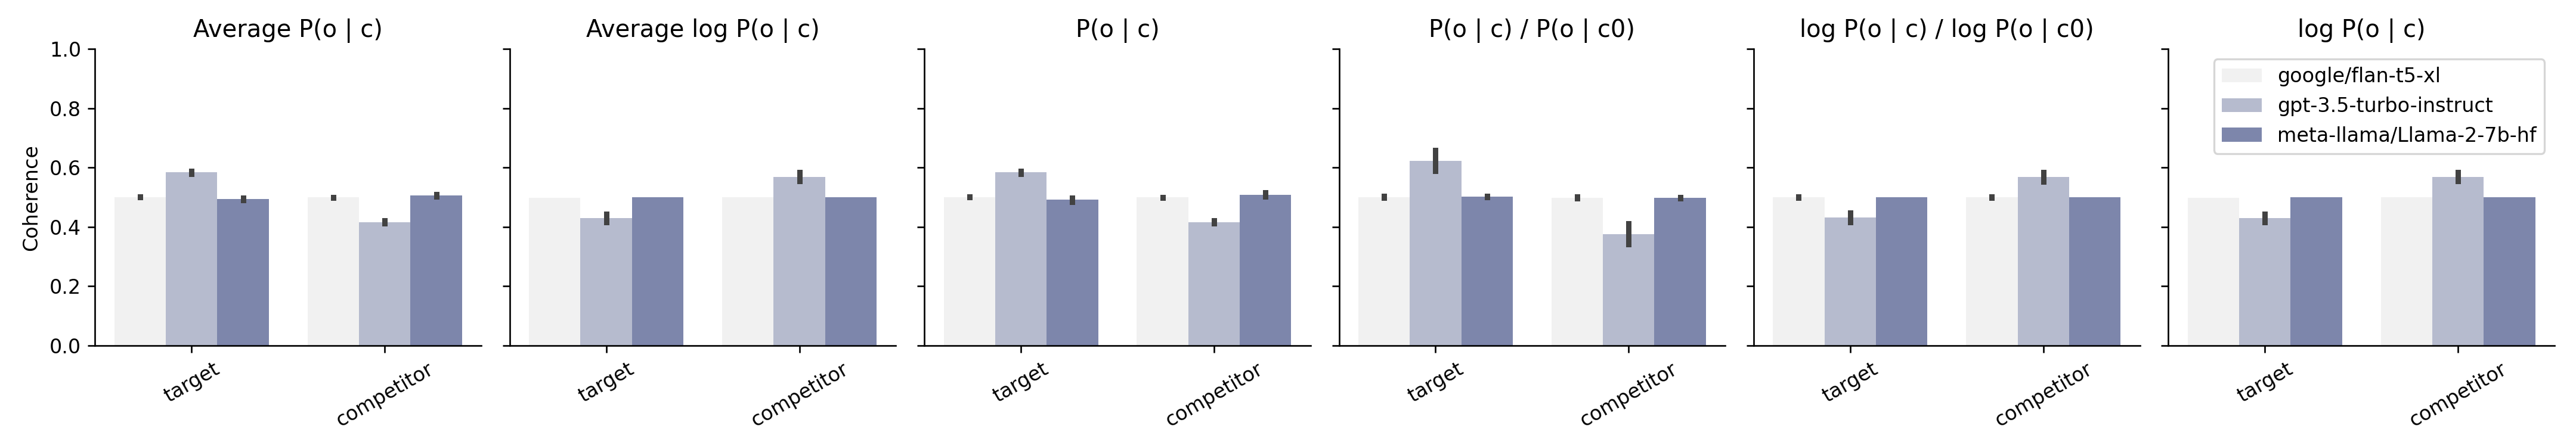

In [390]:
coherence_bar = plot_phenomenon(coherence_avg, ["target", "competitor"])

            model_name            metric_formula phenomenon       metric  \
0    google/flan-t5-xl  mean_sentence_cond_probs    deceits  label_score   
1    google/flan-t5-xl  mean_sentence_cond_probs    deceits  label_score   
2    google/flan-t5-xl   mean_sentence_surprisal    deceits  label_score   
3    google/flan-t5-xl   mean_sentence_surprisal    deceits  label_score   
4    google/flan-t5-xl       sentence_cond_probs    deceits  label_score   
..                 ...                       ...        ...          ...   
104              human   mean_sentence_surprisal    deceits          NaN   
126              human     sentence_mi_surprisal    deceits          NaN   
127              human     sentence_mi_surprisal    deceits          NaN   
128              human     sentence_mi_surprisal    deceits          NaN   
129              human     sentence_mi_surprisal    deceits          NaN   

        label_type        shuffled_option_names     value  
0      label_alpha         

<IPython.core.display.Javascript object>


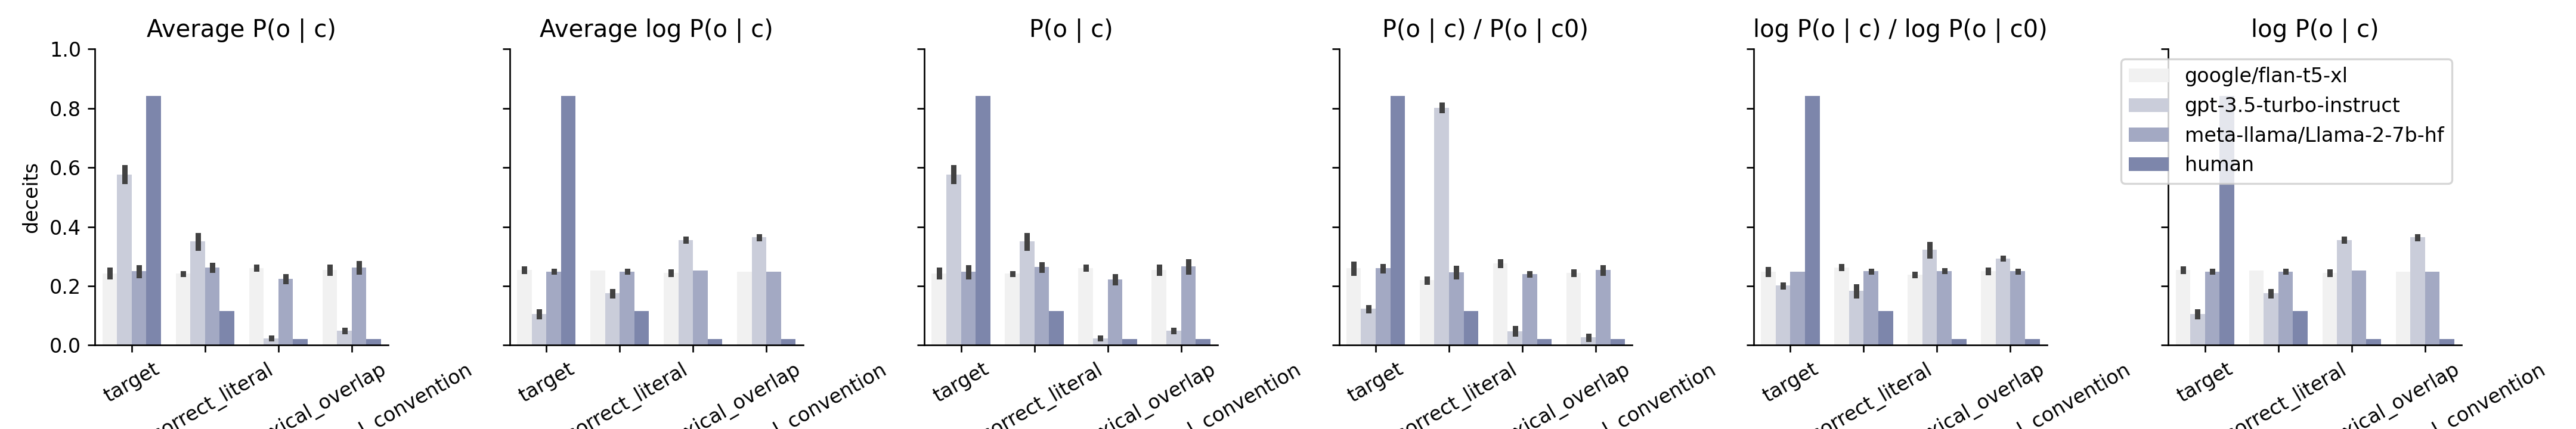

In [391]:
deceits_bar = plot_phenomenon(deceits_avg, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"], "deceits")

            model_name            metric_formula phenomenon       metric  \
0    google/flan-t5-xl  mean_sentence_cond_probs     humour  label_score   
1    google/flan-t5-xl  mean_sentence_cond_probs     humour  label_score   
2    google/flan-t5-xl   mean_sentence_surprisal     humour  label_score   
3    google/flan-t5-xl   mean_sentence_surprisal     humour  label_score   
4    google/flan-t5-xl       sentence_cond_probs     humour  label_score   
..                 ...                       ...        ...          ...   
130              human     sentence_mi_surprisal     humour          NaN   
131              human     sentence_mi_surprisal     humour          NaN   
132              human     sentence_mi_surprisal     humour          NaN   
133              human     sentence_mi_surprisal     humour          NaN   
134              human     sentence_mi_surprisal     humour          NaN   

        label_type      shuffled_option_names     value  
0      label_alpha           

<IPython.core.display.Javascript object>


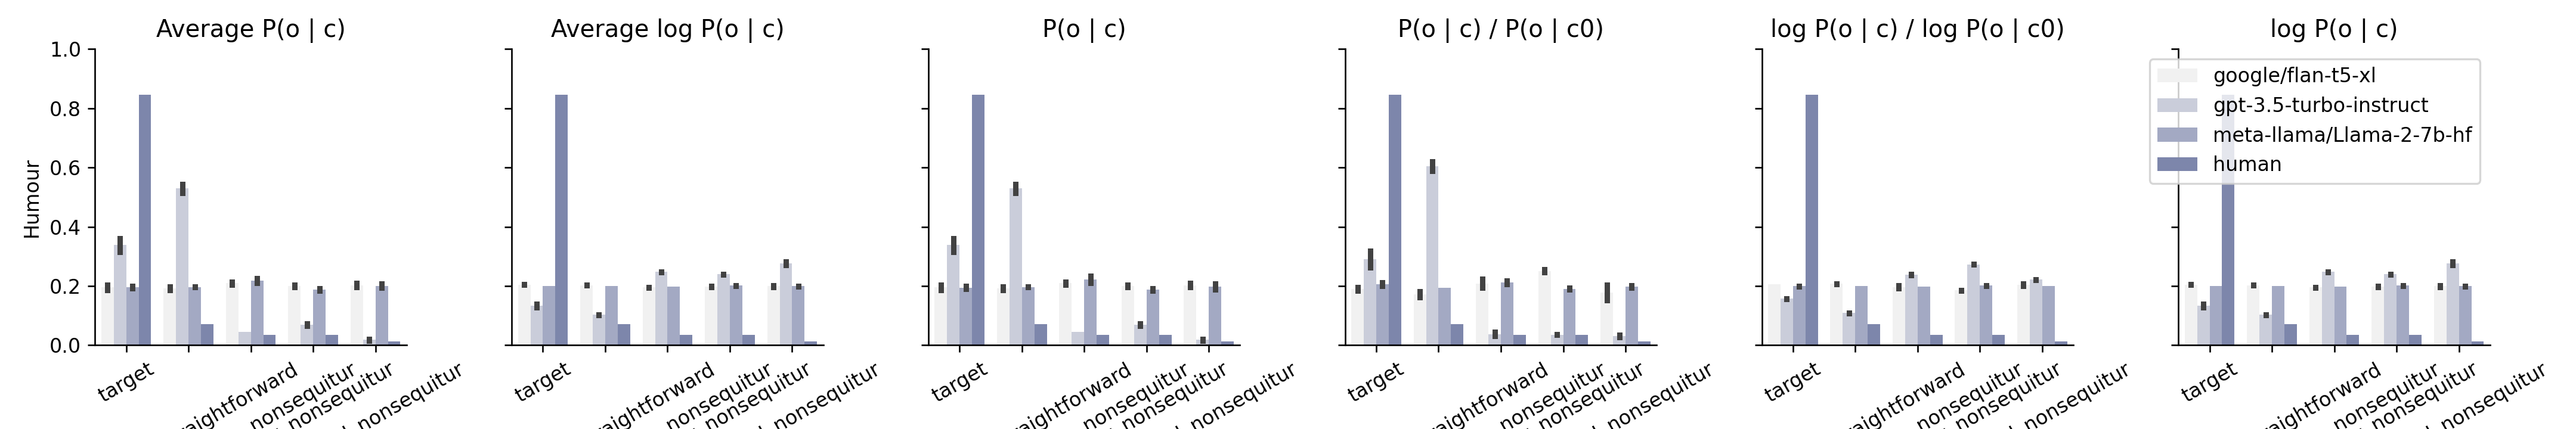

In [392]:
humours_bar = plot_phenomenon(humour_avg, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"], "Humour")

            model_name            metric_formula       phenomenon  \
0    google/flan-t5-xl  mean_sentence_cond_probs  indirect_speech   
1    google/flan-t5-xl  mean_sentence_cond_probs  indirect_speech   
2    google/flan-t5-xl   mean_sentence_surprisal  indirect_speech   
3    google/flan-t5-xl   mean_sentence_surprisal  indirect_speech   
4    google/flan-t5-xl       sentence_cond_probs  indirect_speech   
..                 ...                       ...              ...   
113              human   mean_sentence_surprisal  indirect_speech   
135              human     sentence_mi_surprisal  indirect_speech   
136              human     sentence_mi_surprisal  indirect_speech   
137              human     sentence_mi_surprisal  indirect_speech   
138              human     sentence_mi_surprisal  indirect_speech   

          metric     label_type       shuffled_option_names     value  
0    label_score    label_alpha                      target  0.235737  
1    label_score  label_num

<IPython.core.display.Javascript object>


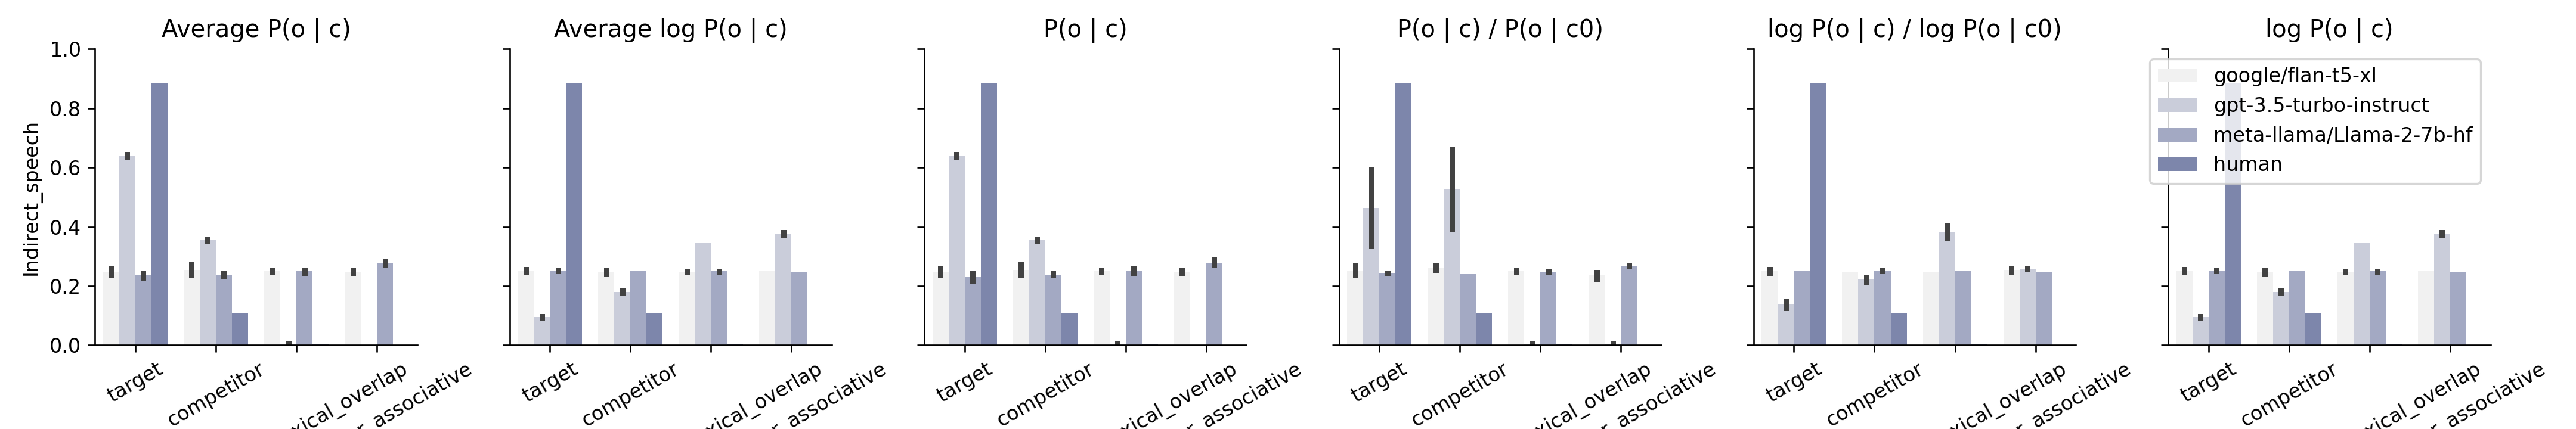

In [394]:
indirect_bar = plot_phenomenon(indirect_avg, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"], "Indirect_speech")

            model_name            metric_formula phenomenon       metric  \
0    google/flan-t5-xl  mean_sentence_cond_probs      irony  label_score   
1    google/flan-t5-xl  mean_sentence_cond_probs      irony  label_score   
2    google/flan-t5-xl   mean_sentence_surprisal      irony  label_score   
3    google/flan-t5-xl   mean_sentence_surprisal      irony  label_score   
4    google/flan-t5-xl       sentence_cond_probs      irony  label_score   
..                 ...                       ...        ...          ...   
117              human   mean_sentence_surprisal      irony          NaN   
139              human     sentence_mi_surprisal      irony          NaN   
140              human     sentence_mi_surprisal      irony          NaN   
141              human     sentence_mi_surprisal      irony          NaN   
142              human     sentence_mi_surprisal      irony          NaN   

        label_type  shuffled_option_names     value  
0      label_alpha               

<IPython.core.display.Javascript object>


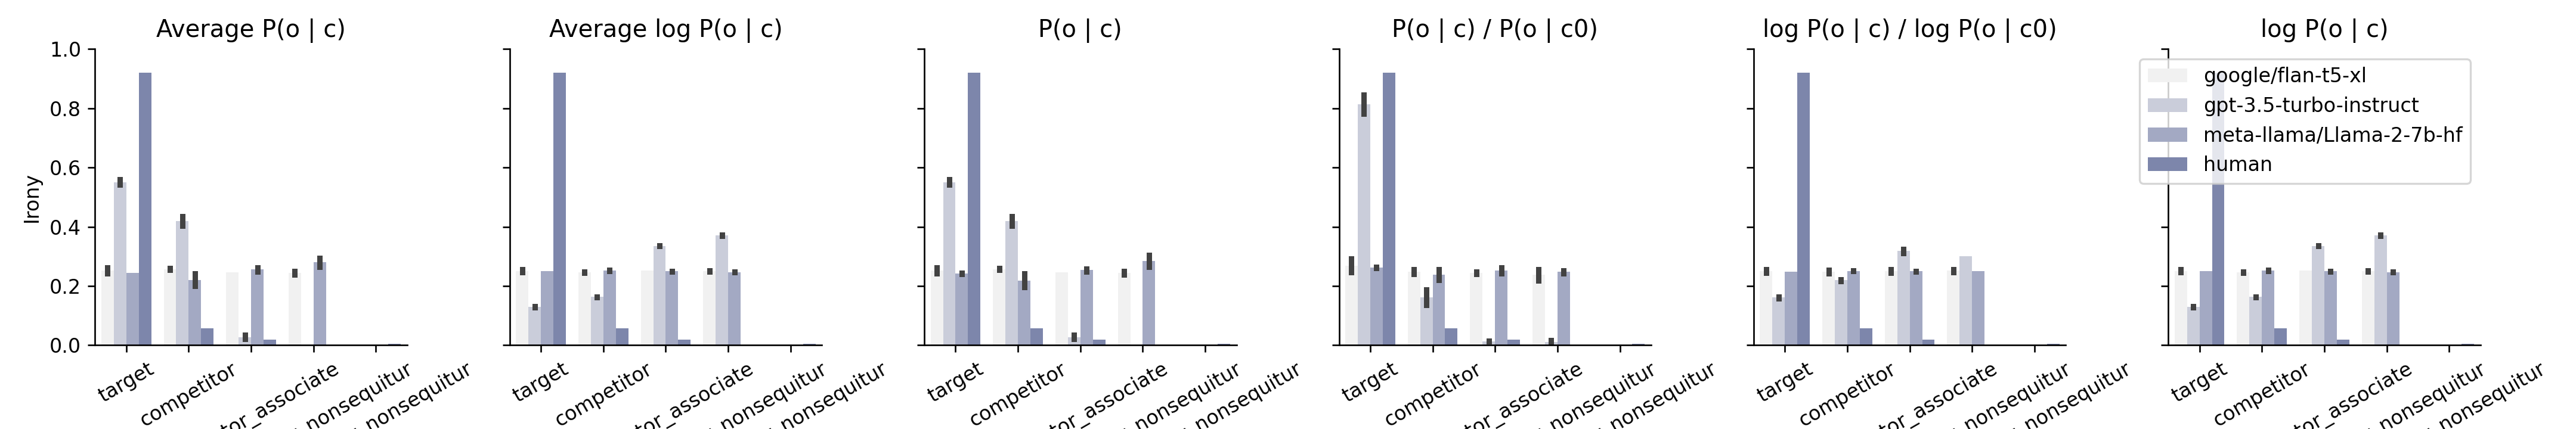

In [395]:
irony_bar = plot_phenomenon(irony_avg, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"], "Irony")

            model_name            metric_formula phenomenon       metric  \
0    google/flan-t5-xl  mean_sentence_cond_probs     maxims  label_score   
1    google/flan-t5-xl  mean_sentence_cond_probs     maxims  label_score   
2    google/flan-t5-xl   mean_sentence_surprisal     maxims  label_score   
3    google/flan-t5-xl   mean_sentence_surprisal     maxims  label_score   
4    google/flan-t5-xl       sentence_cond_probs     maxims  label_score   
..                 ...                       ...        ...          ...   
121              human   mean_sentence_surprisal     maxims          NaN   
143              human     sentence_mi_surprisal     maxims          NaN   
144              human     sentence_mi_surprisal     maxims          NaN   
145              human     sentence_mi_surprisal     maxims          NaN   
146              human     sentence_mi_surprisal     maxims          NaN   

        label_type shuffled_option_names     value  
0      label_alpha                

<IPython.core.display.Javascript object>


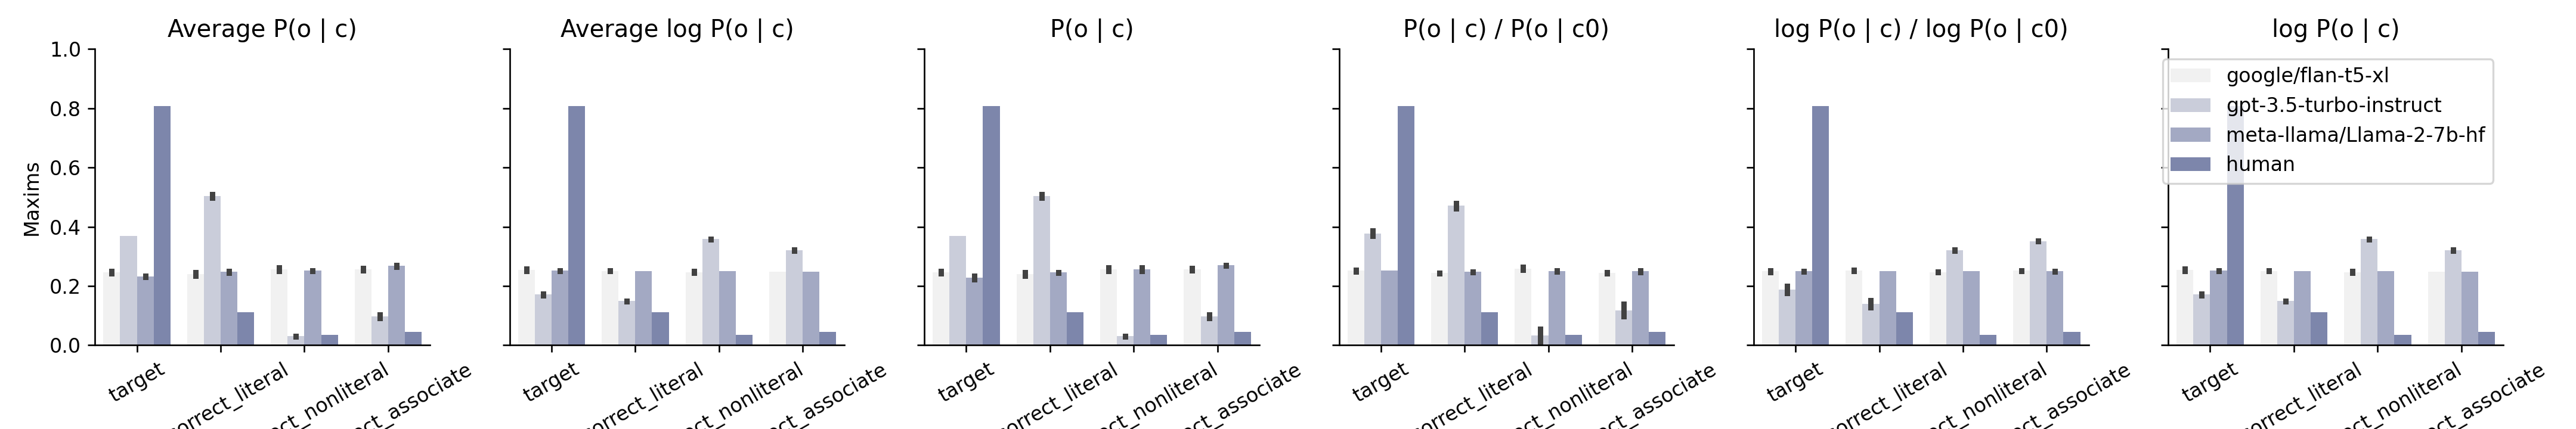

In [396]:
maxims_bar = plot_phenomenon(maxims_avg, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"], "Maxims")

            model_name            metric_formula phenomenon       metric  \
0    google/flan-t5-xl  mean_sentence_cond_probs   metaphor  label_score   
1    google/flan-t5-xl  mean_sentence_cond_probs   metaphor  label_score   
2    google/flan-t5-xl   mean_sentence_surprisal   metaphor  label_score   
3    google/flan-t5-xl   mean_sentence_surprisal   metaphor  label_score   
4    google/flan-t5-xl       sentence_cond_probs   metaphor  label_score   
..                 ...                       ...        ...          ...   
125              human   mean_sentence_surprisal   metaphor          NaN   
147              human     sentence_mi_surprisal   metaphor          NaN   
148              human     sentence_mi_surprisal   metaphor          NaN   
149              human     sentence_mi_surprisal   metaphor          NaN   
150              human     sentence_mi_surprisal   metaphor          NaN   

        label_type   shuffled_option_names     value  
0      label_alpha              

<IPython.core.display.Javascript object>


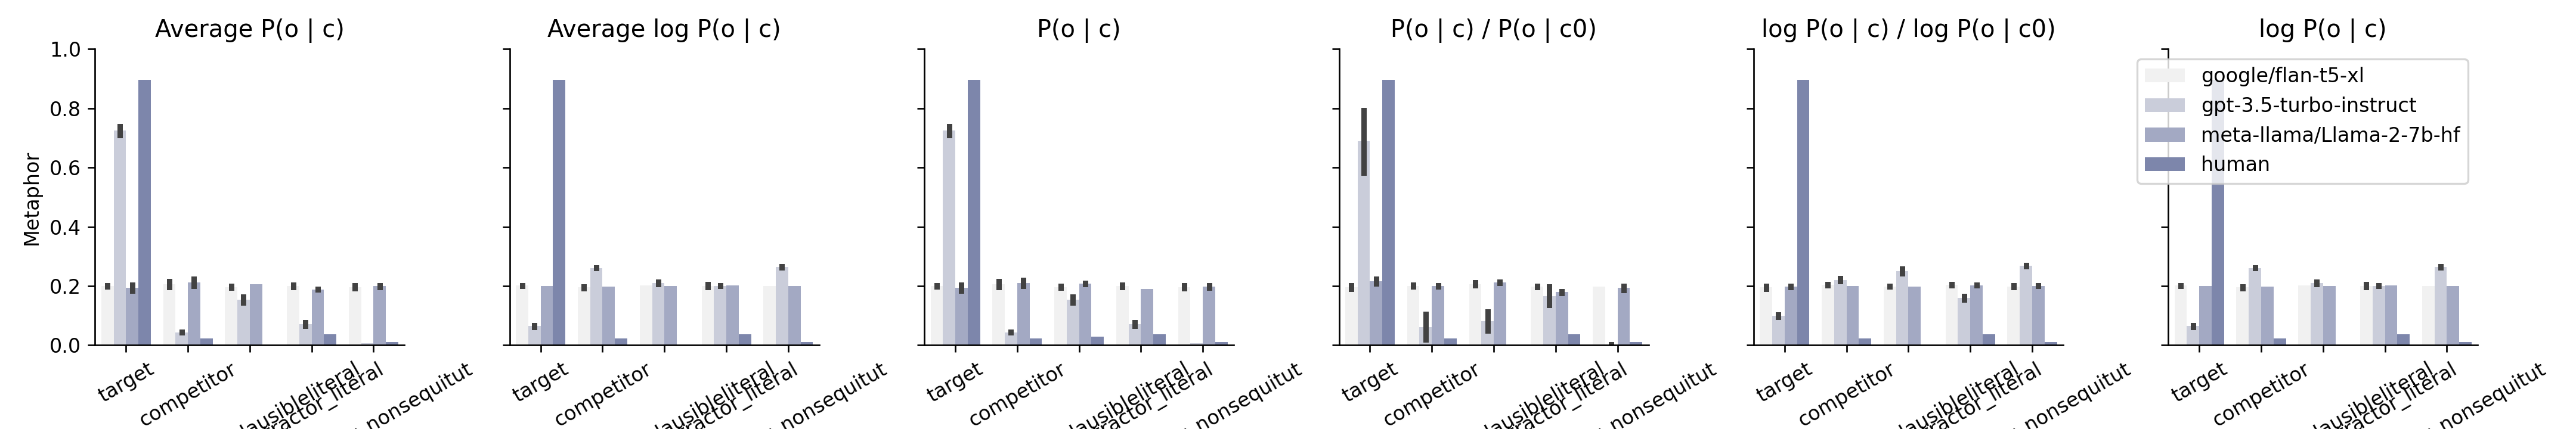

In [397]:
metaphor_bar = plot_phenomenon(metaphor_avg, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"], "Metaphor")

In [359]:
# try applying softmax after averaging
label_scores_raw = pd.concat([coherence_bin,deceits_bin,humour_bin,indirect_bin,irony_bin, maxims_bin,metaphor_bin])

In [165]:
# read human results for the "correlation plot"
df_human_coherence = pd.read_csv("../data/human_results/Human_CoherenceInference.csv") 
df_human_coherence["phenomenon"] = "coherence"
df_human_deceits = pd.read_csv("../data/human_results/Human_Deceits.csv") 
df_human_deceits["phenomenon"] = "deceits"
df_human_humour = pd.read_csv("../data/human_results/Human_Humour.csv") 
df_human_humour["phenomenon"] = "humour"
df_human_indirect = pd.read_csv("../data/human_results/Human_IndirectSpeech.csv") 
df_human_indirect["phenomenon"] = "indirect_speech"
df_human_irony = pd.read_csv("../data/human_results/Human_Irony.csv") 
df_human_irony["phenomenon"] = "irony"
df_human_metaphor = pd.read_csv("../data/human_results/Human_Metaphor.csv") 
df_human_metaphor["phenomenon"] = "metaphor"
df_human_maxims = pd.read_csv("../data/human_results/Human_Maxims.csv") 
df_human_maxims["phenomenon"] = "maxims"

In [166]:
df_human_all = pd.concat([df_human_coherence, df_human_deceits, df_human_humour, df_human_indirect, df_human_irony, df_human_metaphor, df_human_maxims])

In [387]:
26 * 6

156

In [167]:
df_human_summary = df_human_all.groupby(["phenomenon"]).mean("Correct")


In [175]:
df_human_summary = df_human_summary.reset_index()
df_human_summary

,phenomenon,Unnamed: 0,pKey,itemNum,Correct
0,coherence,7480.5,274.371658,20.5,0.856684
1,deceits,3740.5,274.371658,10.5,0.841979
2,humour,4675.5,274.371658,13.0,0.846845
3,indirect_speech,3740.5,274.371658,10.5,0.885963
4,irony,4675.5,274.371658,13.0,0.919465
5,maxims,3740.5,274.371658,10.5,0.795856
6,metaphor,3740.5,274.371658,10.5,0.896791


In [360]:
# add human proportion to model summary
scores_binary_summary_wHuman = scores_binary_summary.copy()

for i, r in scores_binary_summary_wHuman.iterrows():
    phenomenon = r['phenomenon']
    val = float(df_human_summary[df_human_summary["phenomenon"] == phenomenon]['Correct'])
    scores_binary_summary_wHuman.loc[i, 'human'] = val

In [362]:
label_scores_wHuman = label_scores_raw.copy().reset_index()

for i, r in label_scores_wHuman.iterrows():
    phenomenon = r['phenomenon']
    val = float(df_human_summary[df_human_summary["phenomenon"] == phenomenon]['Correct'])
    label_scores_wHuman.loc[i, 'human'] = val

<IPython.core.display.Javascript object>


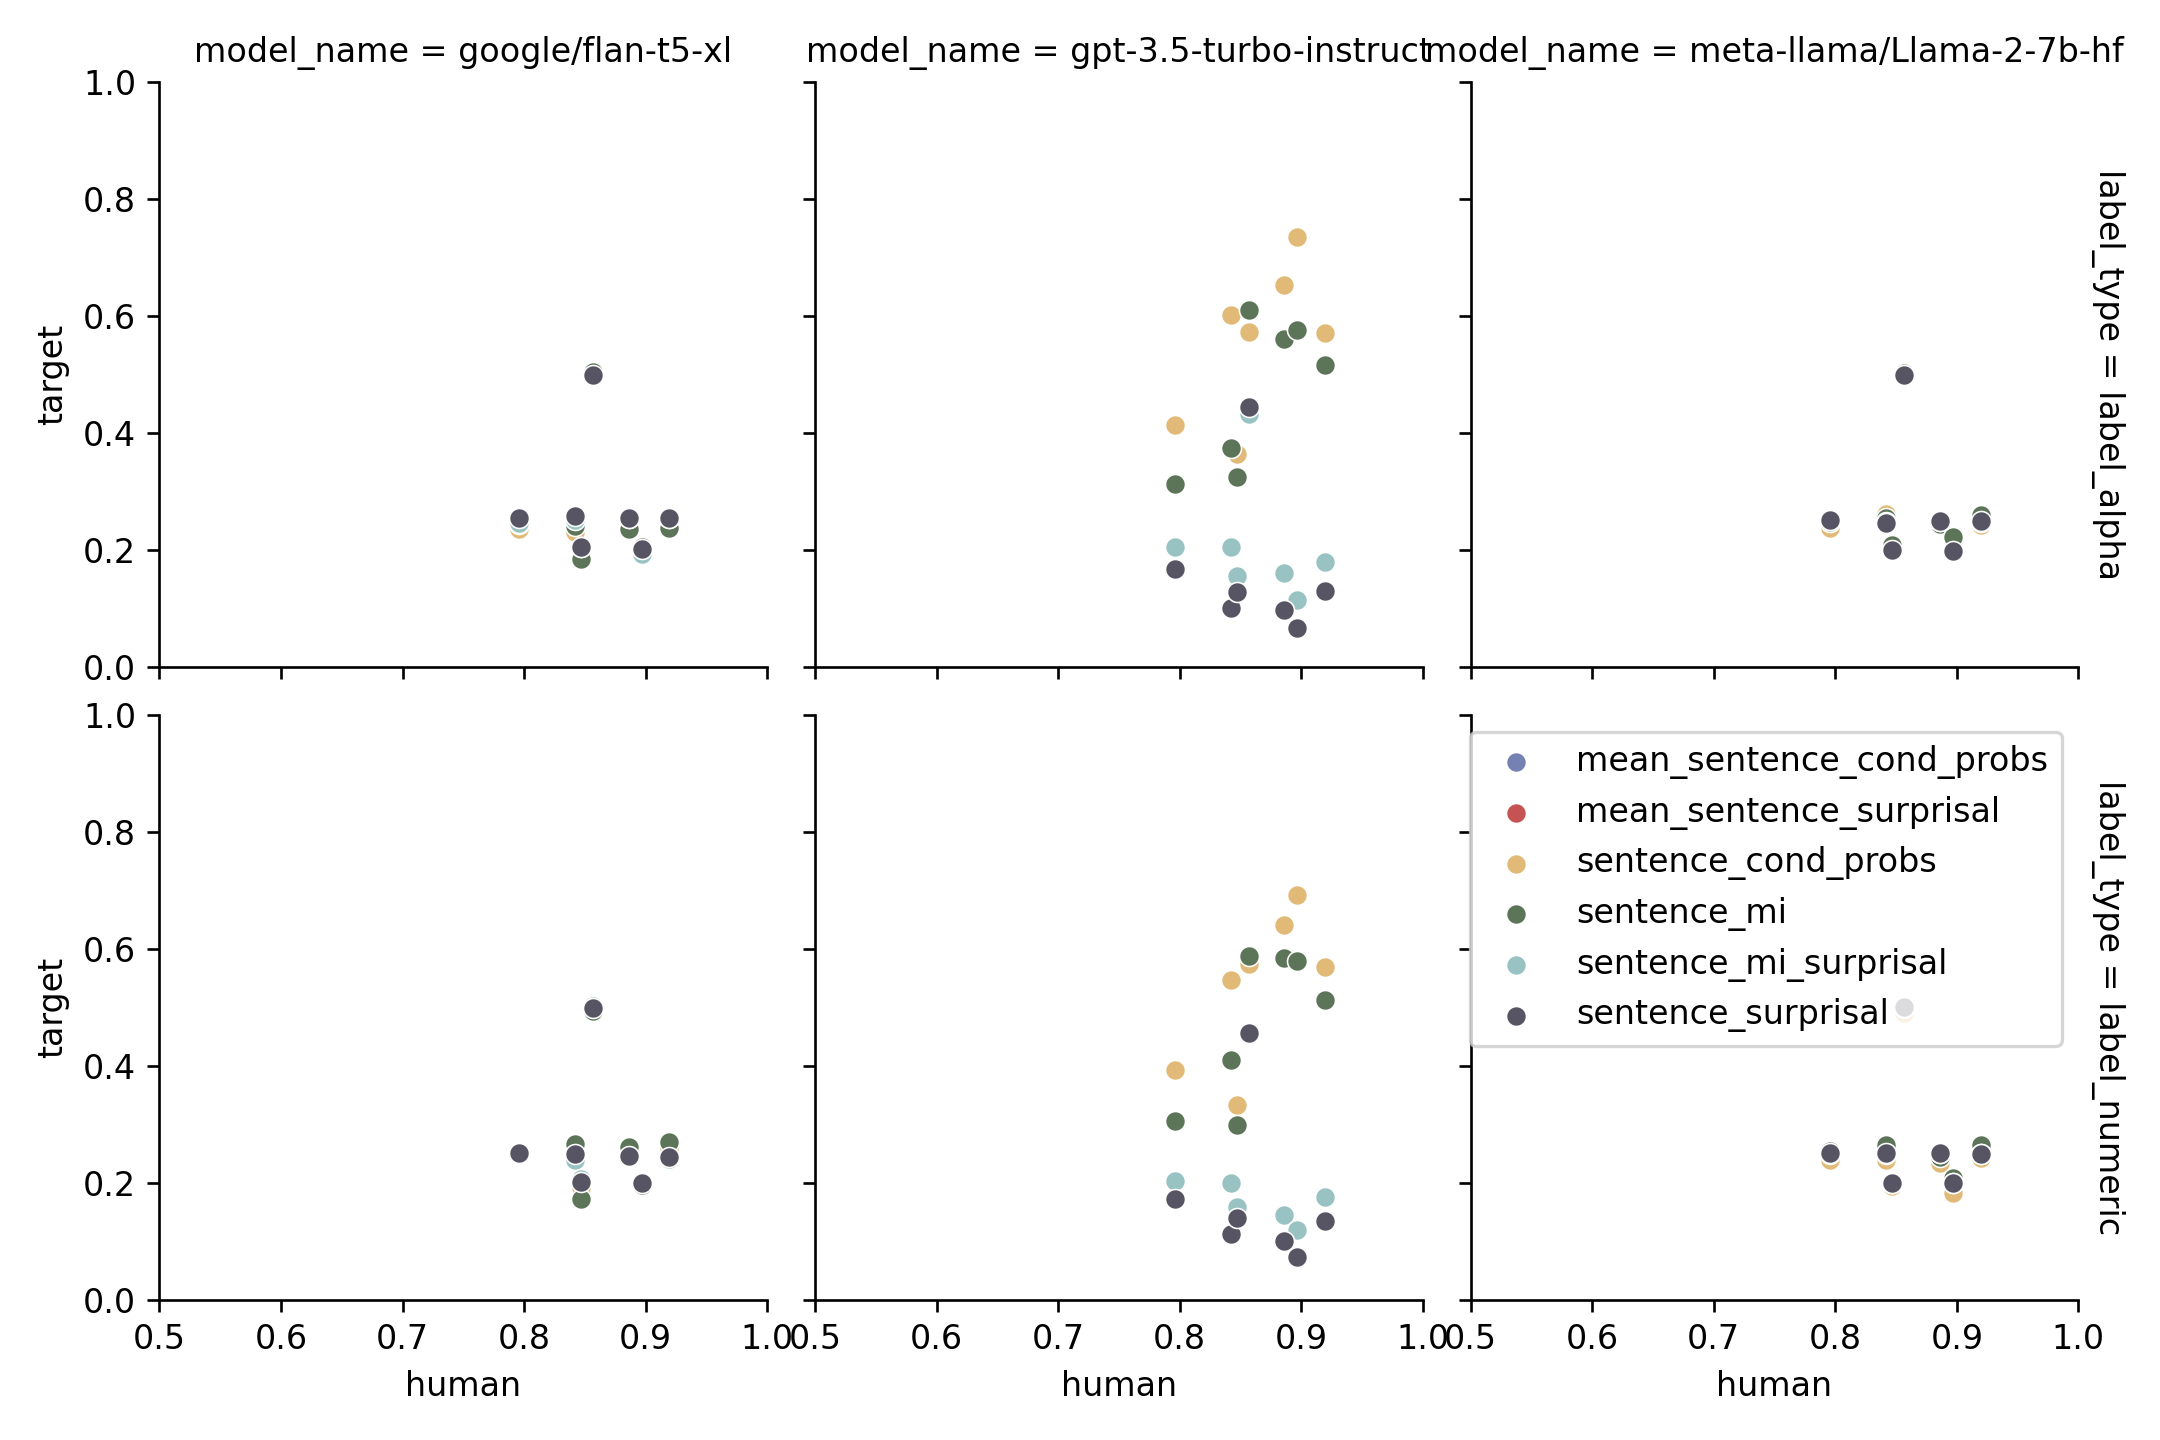

In [365]:
# plotting results by metric, by phenomenon, by model, by label type 
# TODO
scores_binary_summary_wHuman
p1 = sns.FacetGrid(
    scores_binary_summary_wHuman, 
    col="model_name", 
    hue="metric_formula", 
    row="label_type",
    margin_titles=True,
)
p1.map_dataframe(sns.scatterplot, "human", "target")
# sns.scatterplot(data=scores_binary_summary_wHuman, x="human", y="target", hue="phenomenon", style="metric_formula")
plt.xlim(0.5, 1)
plt.ylim(0, 1)
plt.legend()

<IPython.core.display.Javascript object>


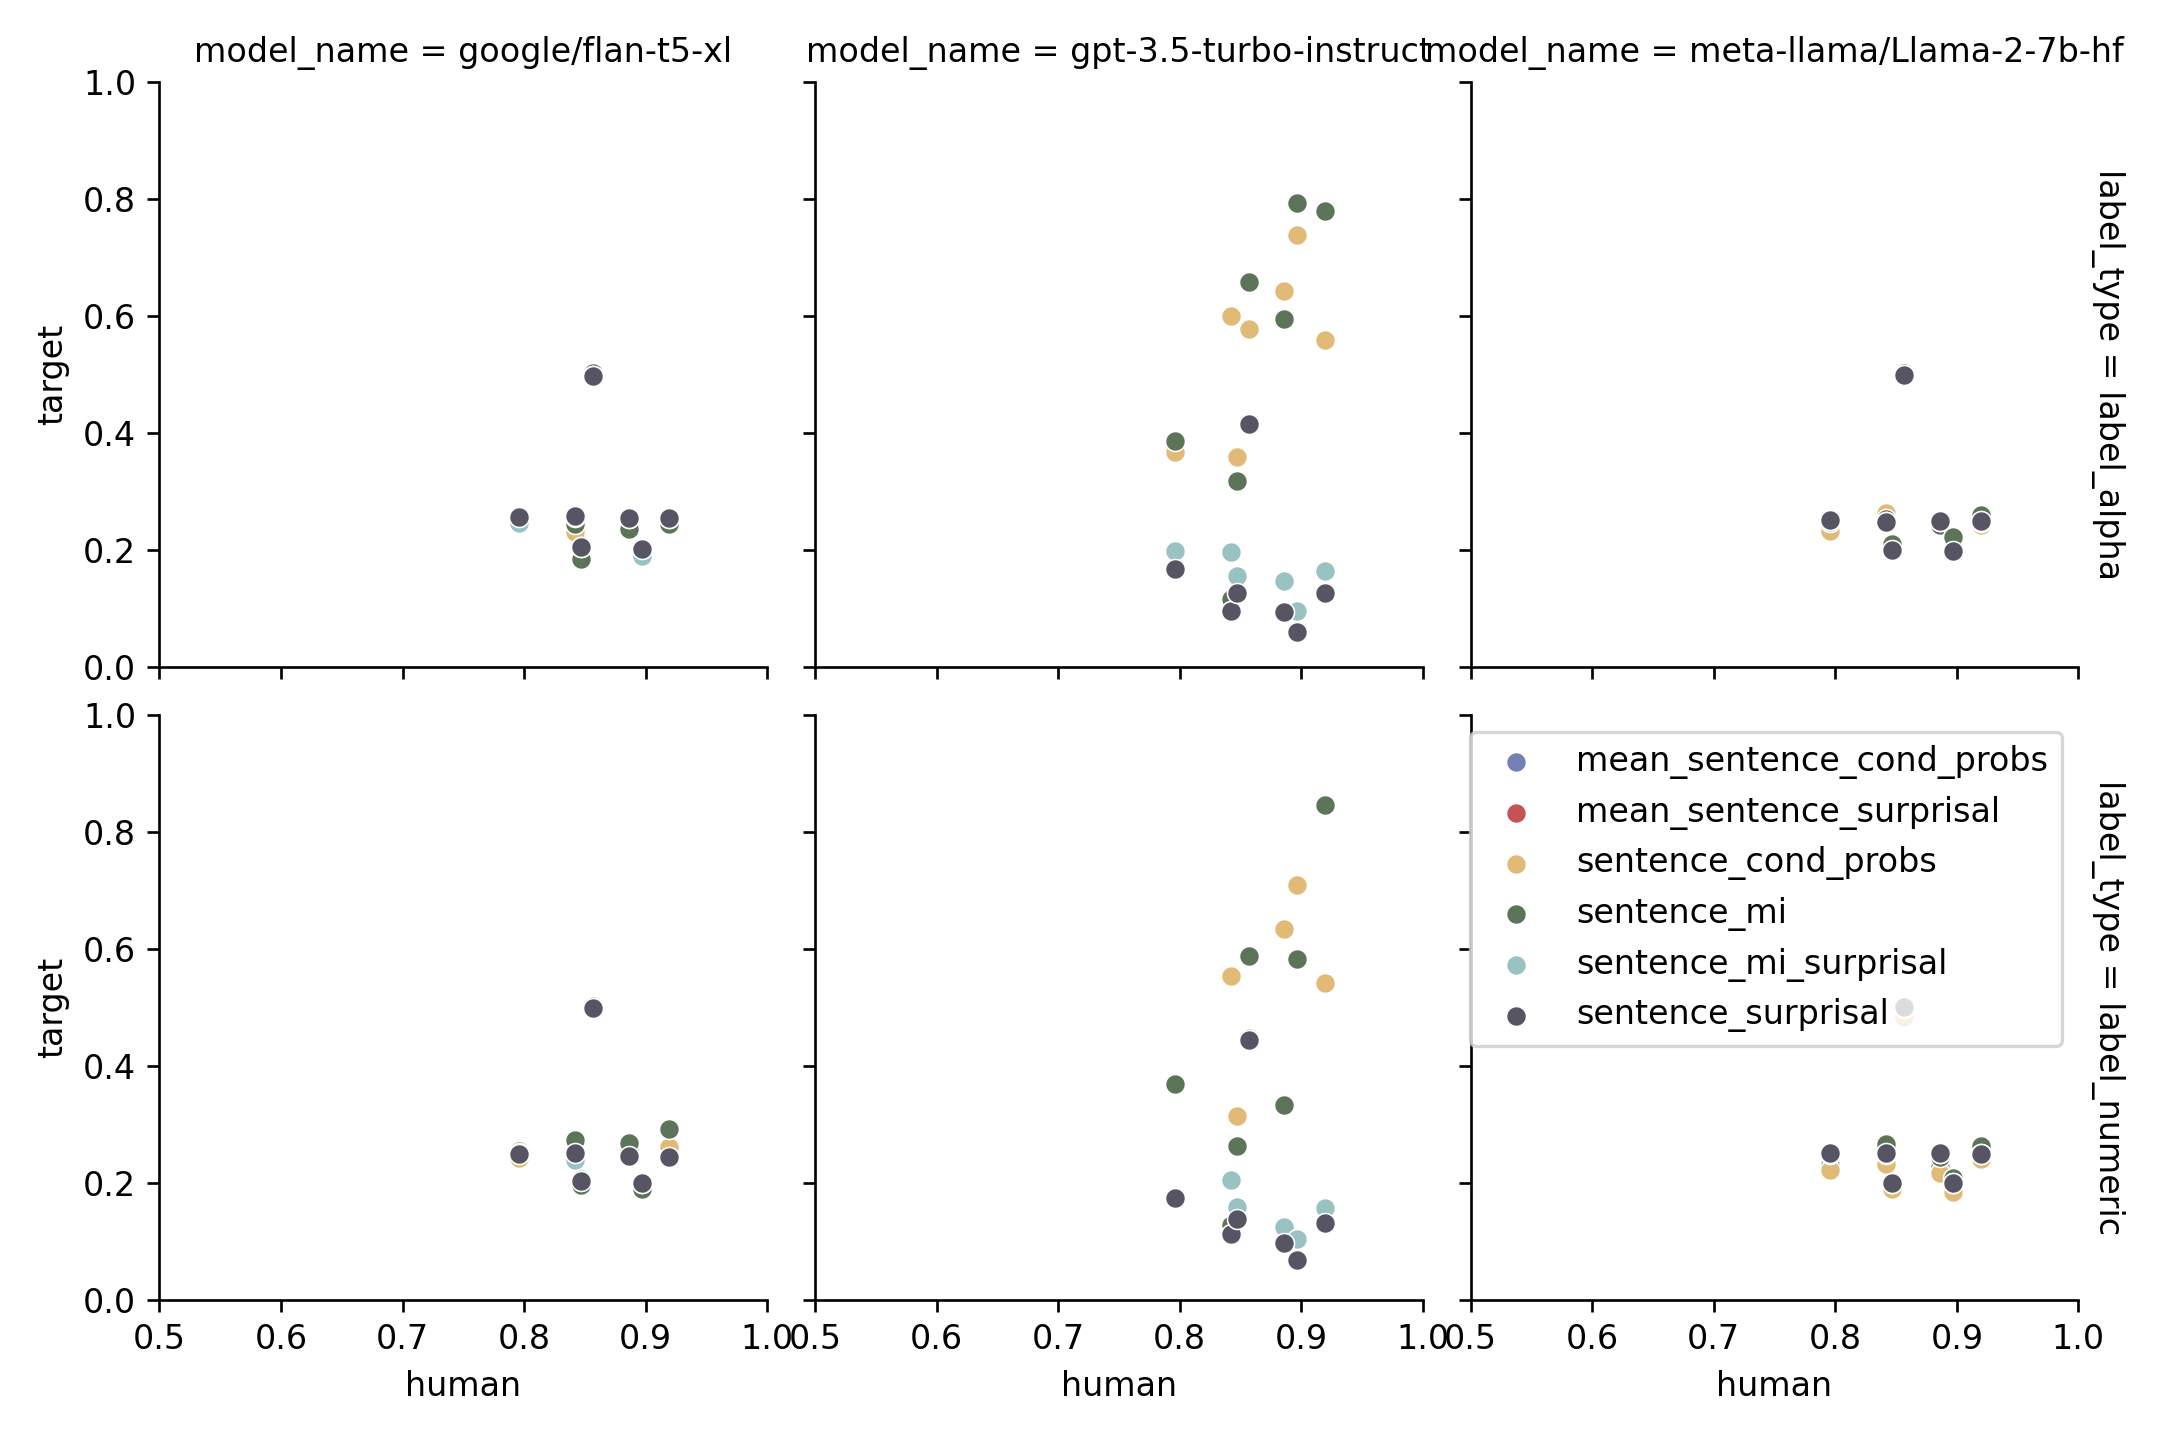

In [366]:
p2 = sns.FacetGrid(
    label_scores_wHuman, 
    col="model_name", 
    hue="metric_formula", 
    row="label_type",
    margin_titles=True,
)
p2.map_dataframe(sns.scatterplot, "human", "target")
# sns.scatterplot(data=scores_binary_summary_wHuman, x="human", y="target", hue="phenomenon", style="metric_formula")
plt.xlim(0.5, 1)
plt.ylim(0, 1)
plt.legend()

In [ ]:
# TODO: double check averaging & softmaxing order (now i first softmaxed, and the averaged -- MF's narrow scope)

In [196]:
scores_binary_summary_wHuman

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,target,distractor_prob,human
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.500000,0.500000,0.856684
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.500000,0.500000,0.856684
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.250000,0.750000,0.841979
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.250000,0.750000,0.841979
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.200000,0.800000,0.846845
...,...,...,...,...,...,...,...,...,...
247,meta-llama/Llama-2-7b-hf,sentence_surprisal,irony,label_numeric,2.0,13.0,0.250496,0.749504,0.919465
248,meta-llama/Llama-2-7b-hf,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.251931,0.748069,0.795856
249,meta-llama/Llama-2-7b-hf,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.251008,0.748992,0.795856
250,meta-llama/Llama-2-7b-hf,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.199456,0.800544,0.896791
